# REALTIME-PROCESS-DETECTION (Single Image Version)

This version processes a **single image** for extracting normalized pose and hand landmarks using MediaPipe Holistic. It is ideal for testing and analyzing static images, especially for training or manual inspection purposes.


In [1]:
# Import required libraries
import cv2 as opencv
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
import math
import numpy as np
import os
from matplotlib import pyplot as plt


## Define Utility Functions

In [2]:
def euclidean_distance(a, b):
    return math.hypot(a.x - b.x, a.y - b.y)

def normalize_landmarks(landmarks, center, scale):
    return [((lm.x - center[0]) / scale, (lm.y - center[1]) / scale) for lm in landmarks]

def draw_landmark_scatter(pose_points, right_hand=None, left_hand=None):
    plt.figure(figsize=(9, 9))
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    if pose_points:
        px, py = zip(*pose_points)
        plt.scatter(px, py, c='blue', label='Pose')
    if right_hand:
        rx, ry = zip(*right_hand)
        plt.scatter(rx, ry, c='green', label='Right Hand')
    if left_hand:
        lx, ly = zip(*left_hand)
        plt.scatter(lx, ly, c='red', label='Left Hand')
    plt.legend()
    plt.title('Normalized Landmarks from Image')
    plt.grid(True)
    plt.xlim(-2.5, 2.5)
    plt.ylim(-2.5, 2.5)
    plt.gca().invert_yaxis()
    plt.show()


## Load and Process a Single Image
Place your image inside the project folder and update the path below.

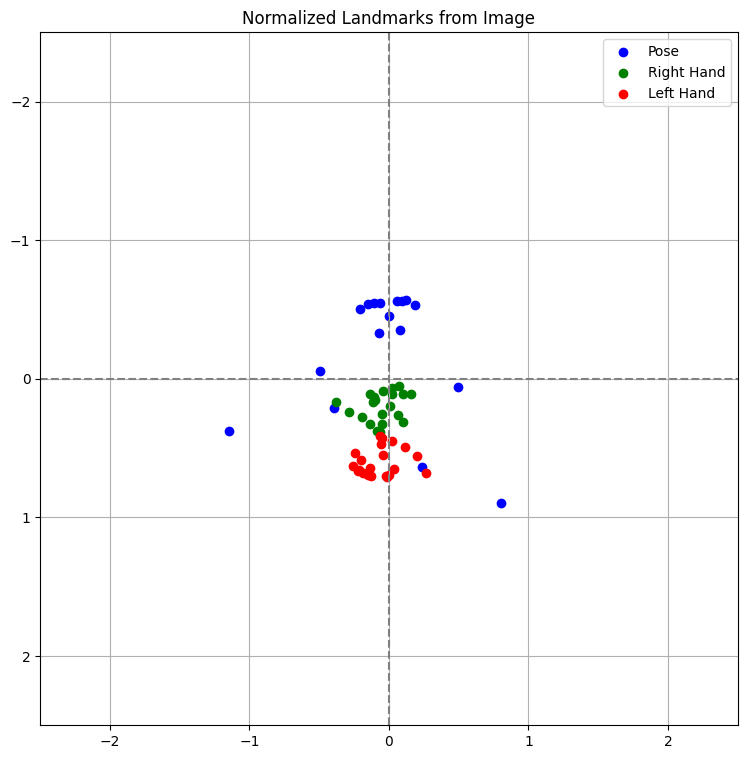

In [3]:
# Define the path to the image
image_path = 'sample_images/example_1.png'  # Change to your image path
image = opencv.imread(image_path)

if image is None:
    raise FileNotFoundError(f"Image not found at {image_path}")

image_rgb = opencv.cvtColor(image, opencv.COLOR_BGR2RGB)

mp_holistic = mp.solutions.holistic
with mp_holistic.Holistic(
    static_image_mode=True,
    model_complexity=1,
    smooth_landmarks=True,
    enable_segmentation=False,
    refine_face_landmarks=False,
    min_detection_confidence=0.5
) as holistic:
    results = holistic.process(image_rgb)

    if results.pose_landmarks:
        pose_lm = results.pose_landmarks.landmark[:17]
        left_shoulder = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.LEFT_SHOULDER]
        right_shoulder = results.pose_landmarks.landmark[mp_holistic.PoseLandmark.RIGHT_SHOULDER]
        shoulder_center = ((left_shoulder.x + right_shoulder.x) / 2, (left_shoulder.y + right_shoulder.y) / 2)
        shoulder_width = euclidean_distance(left_shoulder, right_shoulder)

        norm_pose = normalize_landmarks(pose_lm, shoulder_center, shoulder_width)

        norm_right = normalize_landmarks(results.right_hand_landmarks.landmark, shoulder_center, shoulder_width) if results.right_hand_landmarks else None
        norm_left = normalize_landmarks(results.left_hand_landmarks.landmark, shoulder_center, shoulder_width) if results.left_hand_landmarks else None

        draw_landmark_scatter(norm_pose, norm_right, norm_left)
    else:
        print("Pose landmarks not detected.")

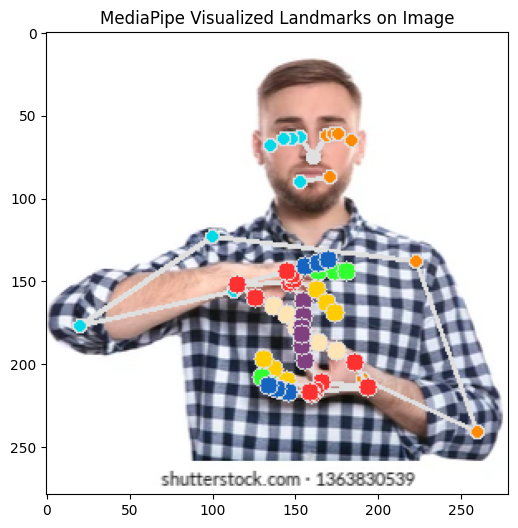

In [4]:
# Initialize mediapipe detection settings
mediapipe_holistic = mp.solutions.holistic
mediapipe_drawing = mp.solutions.drawing_utils
mediapipe_drawing_styles = mp.solutions.drawing_styles

# Draw MediaPipe landmarks on the original image
image_copy = image.copy()
if results.pose_landmarks:

    filtered_pose = landmark_pb2.NormalizedLandmarkList(
        landmark = [results.pose_landmarks.landmark[i] for i in range(17)]
    )

    filtered_connections = [
        conn for conn in mp_holistic.POSE_CONNECTIONS if conn[0] < 17 and conn[1] < 17
    ]

    mediapipe_drawing.draw_landmarks(
        image_copy, 
        filtered_pose, 
        filtered_connections,
        landmark_drawing_spec=mediapipe_drawing_styles.get_default_pose_landmarks_style()
    )
if results.right_hand_landmarks:
    mediapipe_drawing.draw_landmarks(
        image_copy, 
        results.right_hand_landmarks, 
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mediapipe_drawing_styles.get_default_hand_landmarks_style()
    )
if results.left_hand_landmarks:
    mediapipe_drawing.draw_landmarks(
        image_copy, 
        results.left_hand_landmarks, 
        mp_holistic.HAND_CONNECTIONS,
        landmark_drawing_spec=mediapipe_drawing_styles.get_default_hand_landmarks_style()
    )

# Convert BGR to RGB for display
image_rgb_vis = opencv.cvtColor(image_copy, opencv.COLOR_BGR2RGB)
plt.figure(figsize=(8, 6))
plt.imshow(image_rgb_vis)
plt.title('MediaPipe Visualized Landmarks on Image')
plt.axis('on')
plt.show()